In [1]:
import gensim.downloader as api 

wv = api.load('word2vec-google-news-300') #loading the gensim googlenews model 

In [2]:
import pandas as pd 

df = pd.read_csv('Fake_Real_Data.csv')

In [3]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [4]:
df.label.value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [5]:
#creating a new column of 1&0 of label 

df["label_num"] = df.label.map({
    "Fake" : 0 ,
    "Real": 1
})

df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [6]:
#preprocessing the text

import spacy
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(text):
    doc = nlp(text)


    filtered_token = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_token.append(token.lemma_)

    return wv.get_mean_vector(filtered_token) 



In [7]:
preprocess_and_vectorize("Dont worry if you dont understand").shape

(300,)

In [8]:
#we can aslo get the mean of the vectors :

wv.get_mean_vector(["worry", 'understand'], pre_normalize=False)[:3]

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

In [9]:
v1 = wv["worry"]
v2 = wv['understand']

import numpy as np
np.mean([v1,v2], axis=0)[:3]

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

In [10]:
df['vector'] = df['Text'].apply(lambda text : preprocess_and_vectorize(text))

In [11]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


In [12]:
#lets train test and split :

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(df.vector.values, 
                                                    df.label_num, 
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    stratify=df.label_num)



In [13]:
X_train[:3] #we have to reshape it because as you can see each individual element is also numpy array. itsnot a native 2d array  

array([array([-2.58219568e-03,  6.66544260e-03,  2.52646767e-03,  3.95730063e-02,
              -1.41182542e-02, -7.22123589e-03,  3.15938070e-02, -3.18326391e-02,
               1.62770562e-02,  2.15391051e-02, -2.36972049e-02, -3.72144543e-02,
              -6.70092739e-03,  1.64224133e-02, -2.48180293e-02,  4.60469536e-02,
               6.02065027e-03,  2.53213309e-02,  4.08343738e-03, -3.32745500e-02,
               6.01468608e-03,  1.92604307e-02,  4.28487025e-02, -2.15403945e-03,
               2.04510838e-02,  3.04712215e-03, -2.73784697e-02, -1.53319014e-03,
               6.67838380e-03, -3.27401888e-03, -1.53824072e-02,  9.19036320e-05,
              -2.74383668e-02, -3.54807038e-04, -1.12002371e-02, -1.66487973e-02,
               1.40579836e-02,  2.69189221e-03, -4.44610231e-03,  3.41382883e-02,
               5.02199680e-03, -1.35964267e-02,  4.29993980e-02,  1.10096289e-02,
              -5.67582203e-03, -1.63680799e-02, -2.08231565e-02,  8.67405720e-03,
              -1

In [14]:
#Reshaping the X_train and X_test so as to fit for models

print("shape of X_train before reshaping:", X_train.shape)
print("shape of X_test before reshaping:", X_train.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("shape of X_train after reshaping:", X_train_2d.shape)
print("shape of X_test after reshaping:", X_test_2d.shape)

shape of X_train before reshaping: (7920,)
shape of X_test before reshaping: (7920,)
shape of X_train after reshaping: (7920, 300)
shape of X_test after reshaping: (1980, 300)


In [15]:
#Now lets train Machine Learning Model:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


clf = GradientBoostingClassifier()

clf.fit(X_train_2d, y_train)


y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [16]:
#using Naivebayes model :

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler   #as our data contains some negative and postive values the NB will throw an error do overcome this we can scale the data. 

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)


y_pred_nb = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1000
           1       0.95      0.92      0.94       980

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980



In [17]:
#using Randomforest classifier:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create a RandomForest classifier
clf_rf = RandomForestClassifier()

# Train the classifier
clf_rf.fit(X_train_2d, y_train)

# Predict on the test data
y_pred_rf = clf_rf.predict(X_test_2d)

# Print the classification report
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.96      0.98      0.97       980

    accuracy                           0.97      1980
   macro avg       0.97      0.97      0.97      1980
weighted avg       0.97      0.97      0.97      1980



In [18]:
#using Decision tree classifier :

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a DecisionTree classifier
clf_dt = DecisionTreeClassifier()

# Train the classifier
clf_dt.fit(X_train_2d, y_train)

# Predict on the test data
y_pred_dt = clf_dt.predict(X_test_2d)

# Print the classification report
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1000
           1       0.92      0.93      0.93       980

    accuracy                           0.93      1980
   macro avg       0.93      0.93      0.93      1980
weighted avg       0.93      0.93      0.93      1980



In [19]:
#As you can see from all the models the gradient boosting gaev the best performance of alll!! now lets make some predictions :


test_news = [" Top Trump Surrogate BRUTALLY Stabs Him In The Back: ‘He’s Pathetic’ (VIDEO) It s looking as though Republican presidential candidate Donald Trump is losing support even from within his own ranks. You know things are getting bad when even your top surrogates start turning against you, which is exactly what just happened on Fox News when Newt Gingrich called Trump  pathetic. Gingrich knows that Trump needs to keep his focus on Hillary Clinton if he even remotely wants to have a chance at defeating her. However, Trump has hurt feelings because many Republicans don t support his sexual assault against women have turned against him, including House Speaker Paul Ryan (R-WI). So, that has made Trump lash out as his own party.Gingrich said on Fox News: Look, first of all, let me just say about Trump, who I admire and I ve tried to help as much as I can. There s a big Trump and a little Trump. The little Trump is frankly pathetic. I mean, he s mad over not getting a phone call? Trump s referring to the fact that Paul Ryan didn t call to congratulate him after the debate. Probably because he didn t win despite what Trump s ego tells him.Gingrich also added: Donald Trump has one opponent. Her name is Hillary Clinton. Her name is not Paul Ryan. It s not anybody else. Trump doesn t seem to realize that the person he should be mad at is himself because he truly is his own worst enemy. This will ultimately lead to his defeat and he will have no one to blame but himself.Watch here via Politico:Featured Photo by Joe Raedle/Getty Images",
             "Trump on Twitter (August 8): Opioid crisis, North Korea The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - I will be holding a major briefing on the Opioid crisis, a major problem for our country, today at 3:00 P.M. in Bedminster, N.J. [0711 EDT] - After many years of failure, countries are coming together to  finally address the dangers posed by North Korea. We must be tough & decisive! [0717 EDT] - E-mails show that the AmazonWashingtonPost and the FailingNewYorkTimes were reluctant to cover the Clinton/Lynch secret meeting in plane. [1400 EDT] - After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don’t believe the Fake News Suppression Polls! [1410 EDT] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR)",
             "Bond between Trump, Xi in meetings played role in China abstention: U.S. official WASHINGTON (Reuters) - A senior Trump administration official said on Wednesday that the positive bond developed between U.S. President Donald Trump and Chinese President Xi Jinping last week in Florida helped lead to China’s abstention from a U.N. Security Council vote on Syria. The official, who briefed reporters on condition of anonymity, would not say whether Trump personally asked Xi that China not veto the resolution. The official said Xi’s decision not to veto the resolution spoke to China’s determination not to obstruct the U.N.’s ability to sanction Syria for a chemical weapons attack last week. "]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors )

array([0, 1, 1])

The above prdiction is True according to the csv data Hence lets plot confusion matrics :


Text(33.22222222222222, 0.5, 'Truth')

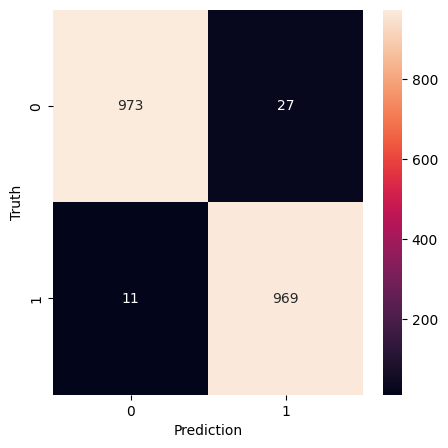

In [20]:
#confusion matrix of Gradientboosting classifier


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,5))
sn.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')